## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df = pd.DataFrame({"x": x, "y": y})

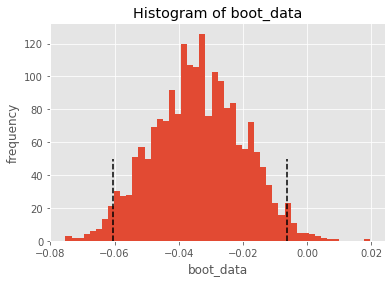

In [4]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [5]:
booted_data["p_value"]

0.015967841910844854

In [6]:
booted_data["ci"]

0
0.025 -0.060541
0.975 -0.006225

### Задача
### 1. Сравните результат между тестом и контролем по двум кейсам:
#### - Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
#### - Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
### 2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

In [7]:
data = pd.read_csv('hw_bootstrap.csv',sep=';') #загружаем csv в переменную data

In [8]:
data.dtypes #проверим типы данных

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [9]:
data.experimentVariant.unique() #посмотрим элементы в "experimentVariant"

array(['Control', 'Treatment'], dtype=object)

In [10]:
data_control_value = data[data.experimentVariant == 'Control'].value.str.replace(',','.').astype(float)
# сохнарим серию значений контрольной группы в float

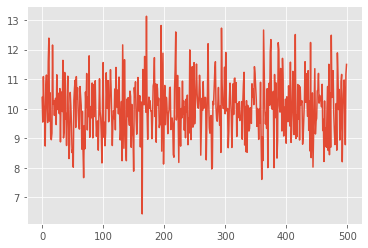

In [11]:
data_control_value.plot() #посмотрим на распределение

In [12]:
data_control_value.describe() #посмотрим на основные стат данные

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64

In [13]:
data_treatment_value = data[data.experimentVariant == 'Treatment'].value.str.replace(',','.').astype(float)
# сохнарим серию значений контрольной группы в float

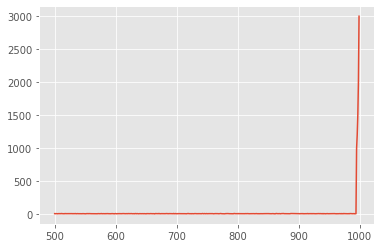

In [14]:
data_treatment_value.plot()
#посмотрим на распределение

In [15]:
data_treatment_value.describe() #посмотрим на основные стат данные

count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64

### Предварительный вывод: в тестовой группе treatment есть значительные выбросы

### Запускаем bootstrap cо статистикой среднее(mean)

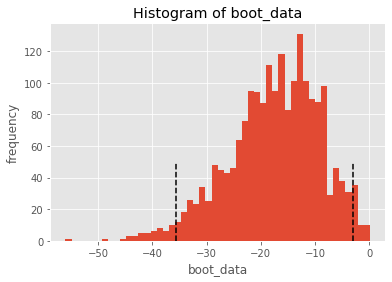

In [16]:
booted_data = get_bootstrap(data_control_value, data_treatment_value, boot_it = 2000)

In [17]:
booted_data["p_value"]

0.03718664182937016

In [18]:
booted_data["ci"]

0
0.025 -35.668934
0.975  -3.050689

In [19]:
mannwhitneyu(x=data_control_value,y=data_treatment_value)[1]

0.8592148582485579

### P-value c помощью Bootstrap mean =  0.037 , что меньше порога 0.05 
### U-test p-value 0.859 , что > порога 0.05 
### Есть подозрение что подобные противоречивые данные можно объяснить значительными выбросами в тестовой группе, которые и повлияли на увеличение среднего значения.  

### Модифицируем функцию get_bootstrap в get_bootstrap_median 

In [20]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

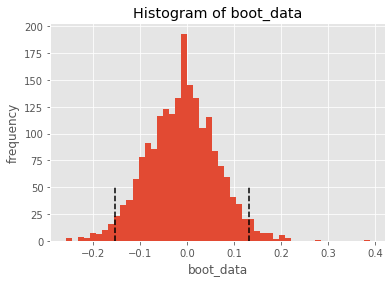

In [21]:
booted_data = get_bootstrap_median(data_control_value, data_treatment_value, boot_it = 2000)

In [22]:
booted_data["p_value"]

0.8804685004301763

In [23]:
booted_data["ci"]

0
0.025 -0.153283
0.975  0.132732

In [24]:
mannwhitneyu(x=data_control_value,y=data_treatment_value)[1]

0.8592148582485579

### P-value bootstrap median показываю обратные от bootstrap mean результаты, p-value  0.88 > 0.05.
### Результаты близко похожи на u-test и подвтерждают наши подозрения о смещенном среднем в первом тесте. Нужно тщательно выбирать критерий теста для A/B - тестов. Благодаря существующим инструментам можно пробовать несколько тестов и выбирать наилучший для разных ситуаций. 

### Напоследок побалуемся библиотекой bootstrapped и посмотрим на ее работу

In [25]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [26]:
print(bs.bootstrap(data_control_value.to_numpy(), stat_func=bs_stats.mean))

10.026866533804297    (9.940246078101065, 10.11222164176972)


In [27]:
print(bs.bootstrap(data_treatment_value.to_numpy(), stat_func=bs_stats.mean)) #кошмарно высокое среднее

27.321499056661573    (9.003170847278277, 41.54594810401949)


In [28]:
print(bs.bootstrap(data_control_value.to_numpy(), stat_func=bs_stats.median))

10.0184651909296    (9.920770083793549, 10.11041639725988)


In [29]:
print(bs.bootstrap(data_treatment_value.to_numpy(), stat_func=bs_stats.median))

10.02584684253515    (9.934635007089701, 10.119433109203477)


### Вопрос к проверяющему: каким образом работая с библиотекой bootstrap можно написать функцию для расчета p-value? Пробовал скопировать из вашего кода но не удалось.